
Satellite Image Classification for Wildfire DetectionProject OverviewThis notebook implements a complete machine learning pipeline for wildfire prediction using satellite imagery. We'll compare two approaches:A custom Convolutional Neural Network (CNN)Transfer learning using a pre-trained ResNet model


# 1. Environment Setup and Data Loading

In [2]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
from pathlib import Path
import os

# Image processing
import cv2

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras - Deep Learning modules
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense,
    Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input  # Preprocessing for ResNet50 input

#To remove warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Ensuring consistent results by setting random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Confirming successful imports
print("Libraries imported successfully!.")
print(f"Using TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.18.0


### Configuration 

In [3]:
# Configuration settings
DATASET_PATH = "/kaggle/input/wildfire-prediction-dataset"
IMG_SIZE = (224, 224)  # Common input dimensions for ResNet and similar CNN architectures
BATCH_SIZE = 32
EPOCHS = 5  # i set this value low because of training time
NUM_CLASSES = 2  # Binary classification: wildfire vs. no wildfire
CLASS_NAMES = ['nowildfire', 'wildfire']  # Two Categories

# Display current setup
print("\n--- Current Setup ---")
print(f"- Dataset directory: {DATASET_PATH}")
print(f"- Target image resolution: {IMG_SIZE}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Epoch count: {EPOCHS}")
print(f"- Total classes: {NUM_CLASSES}")
print(f"- Label mapping: {CLASS_NAMES}")


--- Current Setup ---
- Dataset directory: /kaggle/input/wildfire-prediction-dataset
- Target image resolution: (224, 224)
- Batch size: 32
- Epoch count: 5
- Total classes: 2
- Label mapping: ['nowildfire', 'wildfire']


### Optimized with Generators
checking whether dataset is loaded sucessfully or not

In [4]:
def validate_dataset_layout(dataset_path, expected_splits=['train', 'valid', 'test'], class_labels=CLASS_NAMES):
    """
    Validates whether the dataset directory has the expected structure: 
    train/valid/test splits with proper class subfolders.
    """
    if not os.path.exists(dataset_path):
        print(f"Dataset path does not exist: {dataset_path}")
        return False

    print(f"Found dataset directory: {dataset_path}")

    structure_intact = True
    for split in expected_splits:
        split_path = os.path.join(dataset_path, split)
        if not os.path.isdir(split_path):
            print(f"Missing split directory: {split_path}")
            structure_intact = False
            continue

        # Check if each class folder exists in the split
        for label in class_labels:
            label_path = os.path.join(split_path, label)
            if not os.path.isdir(label_path):
                print(f"Missing class directory: {label_path}")
                structure_intact = False

    if structure_intact:
        print("Dataset structure is valid with all required directories.")
    else:
        print("Dataset structure is incomplete. Please check folder organization.")
        
    return structure_intact

# Run the structure check before proceeding further
if not validate_dataset_layout(DATASET_PATH):
    print("Terminating script due to invalid dataset layout.")
    exit()


Found dataset directory: /kaggle/input/wildfire-prediction-dataset
Dataset structure is valid with all required directories.


# 2. Data Preprocessing and Creating Data Generators

In [5]:
# remove truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
def create_data_generators(dataset_path, img_size, batch_size, class_names):
    """
    Sets up data generators for training, validation, and testing datasets using ImageDataGenerator.
    Training data is augmented, and ResNet50-specific preprocessing is applied to all sets.
    """
    print("\n--- Initializing Data Generators ---")
    
    # Data generator for training with augmentation techniques
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,  # Required preprocessing for ResNet50
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
    )
    
    # Validation and test data generators (no augmentation)
    val_test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input  # Same preprocessing for consistency
    )
    
    # Training generator
    train_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_path, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        classes=class_names,
        seed=42
    )

    # Validation generator
    val_generator = val_test_datagen.flow_from_directory(
        os.path.join(dataset_path, 'valid'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        classes=class_names,
        seed=42
    )

    # Test generator
    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(dataset_path, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        classes=class_names,
        seed=42
    )
    
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    print(f"Test samples: {test_generator.samples}")
    print(f"Class label mapping: {train_generator.class_indices}")
    print("Data generators initialized successfully.")
    
    return train_generator, val_generator, test_generator

# Initialize generators to load the data in real-time
train_gen, val_gen, test_gen = create_data_generators(DATASET_PATH, IMG_SIZE, BATCH_SIZE, CLASS_NAMES)


--- Initializing Data Generators ---
Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Training samples: 30250
Validation samples: 6300
Test samples: 6300
Class label mapping: {'nowildfire': 0, 'wildfire': 1}
Data generators initialized successfully.


# 3. Data Visualization and Quality Assessment

In [6]:
def visualize_generator_samples(generator, n_samples=9, title="Sample Images from Generator"):
    """
    Displays a grid of sample images from the provided generator.
    """
    print(f"\n{title}")
    if generator.samples == 0:
        print("The generator contains no images.")
        return

    # Reset generator to start from the beginning
    generator.reset()

    # Fetch one batch
    X_batch, y_batch = next(generator)

    # Limit number of samples to available images in the batch
    n_samples = min(n_samples, len(X_batch))
    cols = 3
    rows = int(np.ceil(n_samples / cols))

    # Create grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    fig.suptitle(title, fontsize=14)
    axes = axes.flatten()

    for i in range(len(axes)):
        axes[i].axis('off')
        if i < n_samples:
            image = np.clip(X_batch[i], 0, 1)  # Ensure pixel values are within displayable range
            label = CLASS_NAMES[int(y_batch[i])]
            axes[i].imshow(image)
            axes[i].set_title(label, fontsize=10)

    plt.tight_layout()
    plt.show()


Training Set Samples


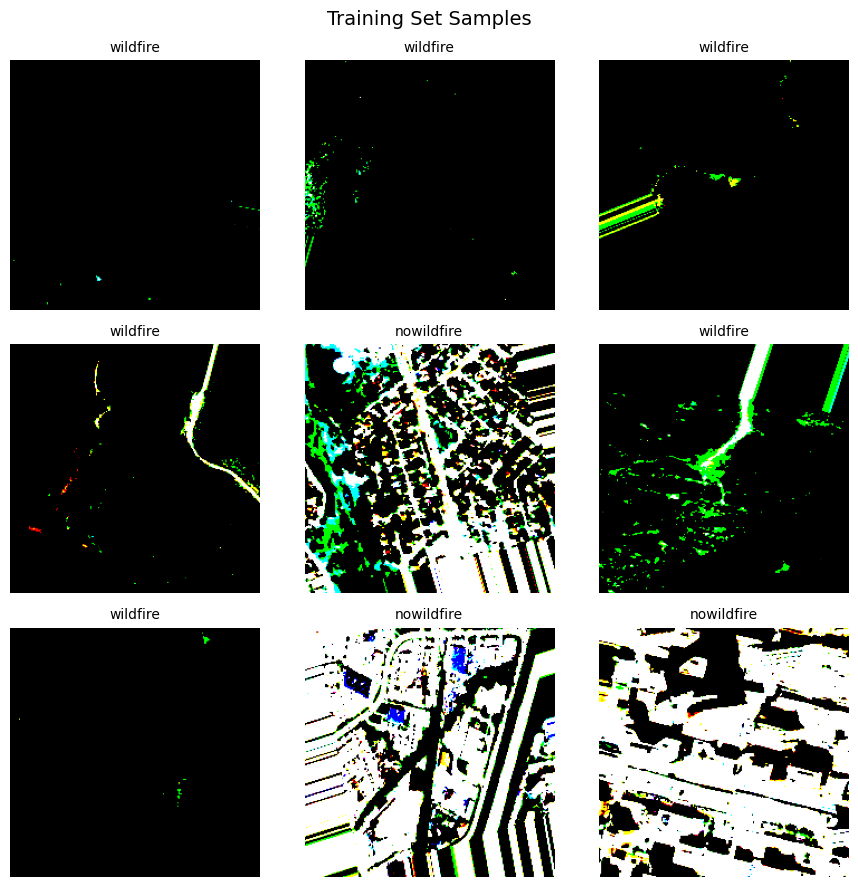

In [7]:
visualize_generator_samples(train_gen, n_samples=9, title="Training Set Samples")

# 4. Model Architecture Development

## 4.1 Custom CNN Architecture

In [8]:
def create_custom_cnn(input_shape=(224, 224, 3)):
    """
    Builds a custom Convolutional Neural Network aimed at binary classification
    of wildfire and non-wildfire satellite images.

    Model Design:
    - Stacked convolution layers to extract both low-level and high-level spatial features.
    - BatchNormalization layers to stabilize learning and speed up convergence.
    - Dropout layers to reduce overfitting by randomly deactivating neurons.
    - MaxPooling to progressively downsample feature maps.
    - Dense layers at the end for final classification.
    """

    model = Sequential([
        # Block 1: Basic feature extraction
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 2: Deeper representation
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 3: Higher complexity features
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 4: Abstract patterns
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Output head
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])

    return model

# Build and compile the model
print("\n--- Creating Custom CNN ---")
custom_cnn = create_custom_cnn(input_shape=IMG_SIZE + (3,))

custom_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Model compiled successfully.")
print(f"Trainable parameters: {custom_cnn.count_params():,}")
custom_cnn.summary()


--- Creating Custom CNN ---


I0000 00:00:1749583327.306195      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749583327.307020      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model compiled successfully.
Trainable parameters: 26,999,457


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,999,457 (102.99 MB)

 Trainable params: 26,996,961 (102.99 MB)

 Non-trainable params: 2,496 (9.75 KB)

## 4.2 Transfer Learning with ResNet50

In [9]:
def create_transfer_learning_model(input_shape=(224, 224, 3)):
    """
    Builds a model for wildfire classification using ResNet50 as a fixed feature extractor.

    Approach:
    - Leverages ResNet50 pre-trained on ImageNet to extract general image features.
    - Freezes the ResNet base to retain its learned filters.
    - Adds custom layers on top to adapt to the wildfire classification task.
    - Ideal for reducing training time and improving performance with limited data.
    """
    
    # Load ResNet50 base without the classification layers
    base_model = ResNet50(
        weights='imagenet',        # Load pretrained ImageNet weights
        include_top=False,         # Omit the original classification head
        input_shape=input_shape    # Match our input dimensions
    )

    # Prevent base model weights from being updated during training
    base_model.trainable = False

    # Stack custom layers on top of the base model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),          # Pooling to reduce dimensions
        Dense(256, activation='relu'),     # First dense layer
        BatchNormalization(),              # Normalize activations
        Dropout(0.5),                      # Prevent overfitting
        Dense(128, activation='relu'),     # Second dense layer
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')     # Final output for binary classification
    ])

    return model

# Build and compile the transfer learning model
print("\n--- Building Transfer Learning Model (ResNet50) ---")
transfer_model = create_transfer_learning_model(input_shape=IMG_SIZE + (3,))  # (224, 224, 3)

transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Transfer learning model is ready.")
print(f"Total parameters: {transfer_model.count_params():,}")
trainable_params = sum([tf.size(w).numpy() for w in transfer_model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
transfer_model.summary()



--- Building Transfer Learning Model (ResNet50) ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Transfer learning model is ready.
Total parameters: 24,146,817
Trainable parameters: 558,337


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,146,817 (92.11 MB)

 Trainable params: 558,337 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

## 5. Model Training

In [11]:
def create_training_callbacks():
    """
    Defines key callbacks to optimize training:
    - EarlyStopping: Halts training if validation loss doesn’t improve for a few epochs.
    - ReduceLROnPlateau: Lowers the learning rate when progress stalls to aid convergence.
    """
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=4,
            min_lr=1e-7,
            verbose=1
        )
    ]
    return callbacks

# Initialize callbacks
callbacks = create_training_callbacks()

print("\n--- Training Custom CNN ---")

# Compute steps per epoch based on dataset size and batch size
steps_per_epoch_train = train_gen.samples // train_gen.batch_size
steps_per_epoch_val = val_gen.samples // val_gen.batch_size

# Ensure generators have data before training
if train_gen.samples > 0 and val_gen.samples > 0:
    cnn_history = custom_cnn.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch_train,
        epochs=EPOCHS,
        validation_data=val_gen,
        validation_steps=steps_per_epoch_val,
        callbacks=callbacks,
        verbose=1
    )
    print("Custom CNN training finished.")
else:
    print("Training skipped: training or validation generator is empty.")
    cnn_history = None


--- Training Custom CNN ---
Epoch 1/5


I0000 00:00:1749555687.948774     120 service.cc:148] XLA service 0x1b011910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749555687.949662     120 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749555687.949683     120 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749555688.904523     120 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749555709.217607     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


945/945 ━━━━━━━━━━━━━━━━━━━━ 732s 742ms/step - accuracy: 0.8977 - loss: 0.2822 - precision: 0.8918 - recall: 0.9153 - val_accuracy: 0.8119 - val_loss: 0.4084 - val_precision: 0.7459 - val_recall: 0.9983 - learning_rate: 0.0010
Epoch 2/5
945/945 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9375 - loss: 0.1540 - precision: 0.8889 - recall: 1.0000 - val_accuracy: 0.8120 - val_loss: 0.4090 - val_precision: 0.7460 - val_recall: 0.9983 - learning_rate: 0.0010
Epoch 3/5
945/945 ━━━━━━━━━━━━━━━━━━━━ 453s 480ms/step - accuracy: 0.9265 - loss: 0.1893 - precision: 0.9197 - recall: 0.9417 - val_accuracy: 0.8351 - val_loss: 0.4966 - val_precision: 0.7707 - val_recall: 0.9971 - learning_rate: 0.0010
Epoch 4/5
945/945 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9062 - loss: 0.2304 - precision: 0.8824 - recall: 0.9375 - val_accuracy: 0.8466 - val_loss: 0.4587 - val_precision: 0.7832 - val_recall: 0.9974 - learning_rate: 0.0010
Epoch 4: early stopping
Restoring model weights from the end of th

In [12]:
# Train Transfer Learning Model
print("\n--- Training Transfer Learning Model (ResNet50) ---")

if train_gen.samples > 0 and val_gen.samples > 0:
    transfer_history = transfer_model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch_train,
        epochs=EPOCHS,
        validation_data=val_gen,
        validation_steps=steps_per_epoch_val,
        callbacks=callbacks,
        verbose=1
    )
    print("✓ Transfer learning model training completed.")
else:
    print("Skipping Transfer Learning model training as train/validation data is empty.")
    transfer_history = None


--- Training Transfer Learning Model (ResNet50) ---
Epoch 1/5
945/945 ━━━━━━━━━━━━━━━━━━━━ 506s 512ms/step - accuracy: 0.9224 - loss: 0.1984 - precision: 0.9202 - recall: 0.9318 - val_accuracy: 0.9598 - val_loss: 0.0997 - val_precision: 0.9834 - val_recall: 0.9429 - learning_rate: 0.0010
Epoch 2/5
945/945 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.9688 - loss: 0.0565 - precision: 0.9333 - recall: 1.0000 - val_accuracy: 0.9601 - val_loss: 0.0996 - val_precision: 0.9834 - val_recall: 0.9435 - learning_rate: 0.0010
Epoch 3/5
945/945 ━━━━━━━━━━━━━━━━━━━━ 467s 495ms/step - accuracy: 0.9512 - loss: 0.1364 - precision: 0.9481 - recall: 0.9583 - val_accuracy: 0.9705 - val_loss: 0.0864 - val_precision: 0.9846 - val_recall: 0.9615 - learning_rate: 0.0010
Epoch 4/5
945/945 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.9688 - loss: 0.1040 - precision: 1.0000 - recall: 0.9333 - val_accuracy: 0.9707 - val_loss: 0.0866 - val_precision: 0.9849 - val_recall: 0.9615 - learning_rate: 0.0010
Epo

# 6. Training Analysis and Visualization

In [28]:
# --- 6. Training Analysis and Visualization ---
def plot_training_history(history1, history2, model1_name="Custom CNN", model2_name="Transfer Learning"):
    """
    Visualize and compare performance metrics (Accuracy, Loss, Precision, Recall)
    for two different models across training epochs.
    """
    if history1 is None and history2 is None:
        print("No training records available for visualization.")
        return

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comparison of Training Progress', fontsize=16, fontweight='bold')
    
    histories = {model1_name: history1, model2_name: history2}
    
    metrics = {
        'accuracy': 'Accuracy Over Epochs',
        'loss': 'Loss Over Epochs',
        'precision': 'Precision Over Epochs',
        'recall': 'Recall Over Epochs'
    }

    plot_positions = {
        'accuracy': (0, 0),
        'loss': (0, 1),
        'precision': (0, 2),
        'recall': (1, 0)
    }

    for metric, title in metrics.items():
        row, col = plot_positions[metric]
        for name, history in histories.items():
            if history is not None and metric in history.history:
                axes[row, col].plot(history.history[metric], label=f'{name} Train', linewidth=2)
                axes[row, col].plot(history.history[f'val_{metric}'], label=f'{name} Val', linewidth=2, linestyle='--')
        axes[row, col].set_title(title)
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel(metric.capitalize())
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    
    # Summary placeholder subplot
    axes[1, 1].text(0.5, 0.5, 'Training\nCompleted', ha='center', va='center', 
                   transform=axes[1, 1].transAxes, fontsize=20, fontweight='bold')
    axes[1, 1].set_title('Summary')
    axes[1, 1].axis('off')

## Final metrics comparison

<Figure size 640x480 with 0 Axes>

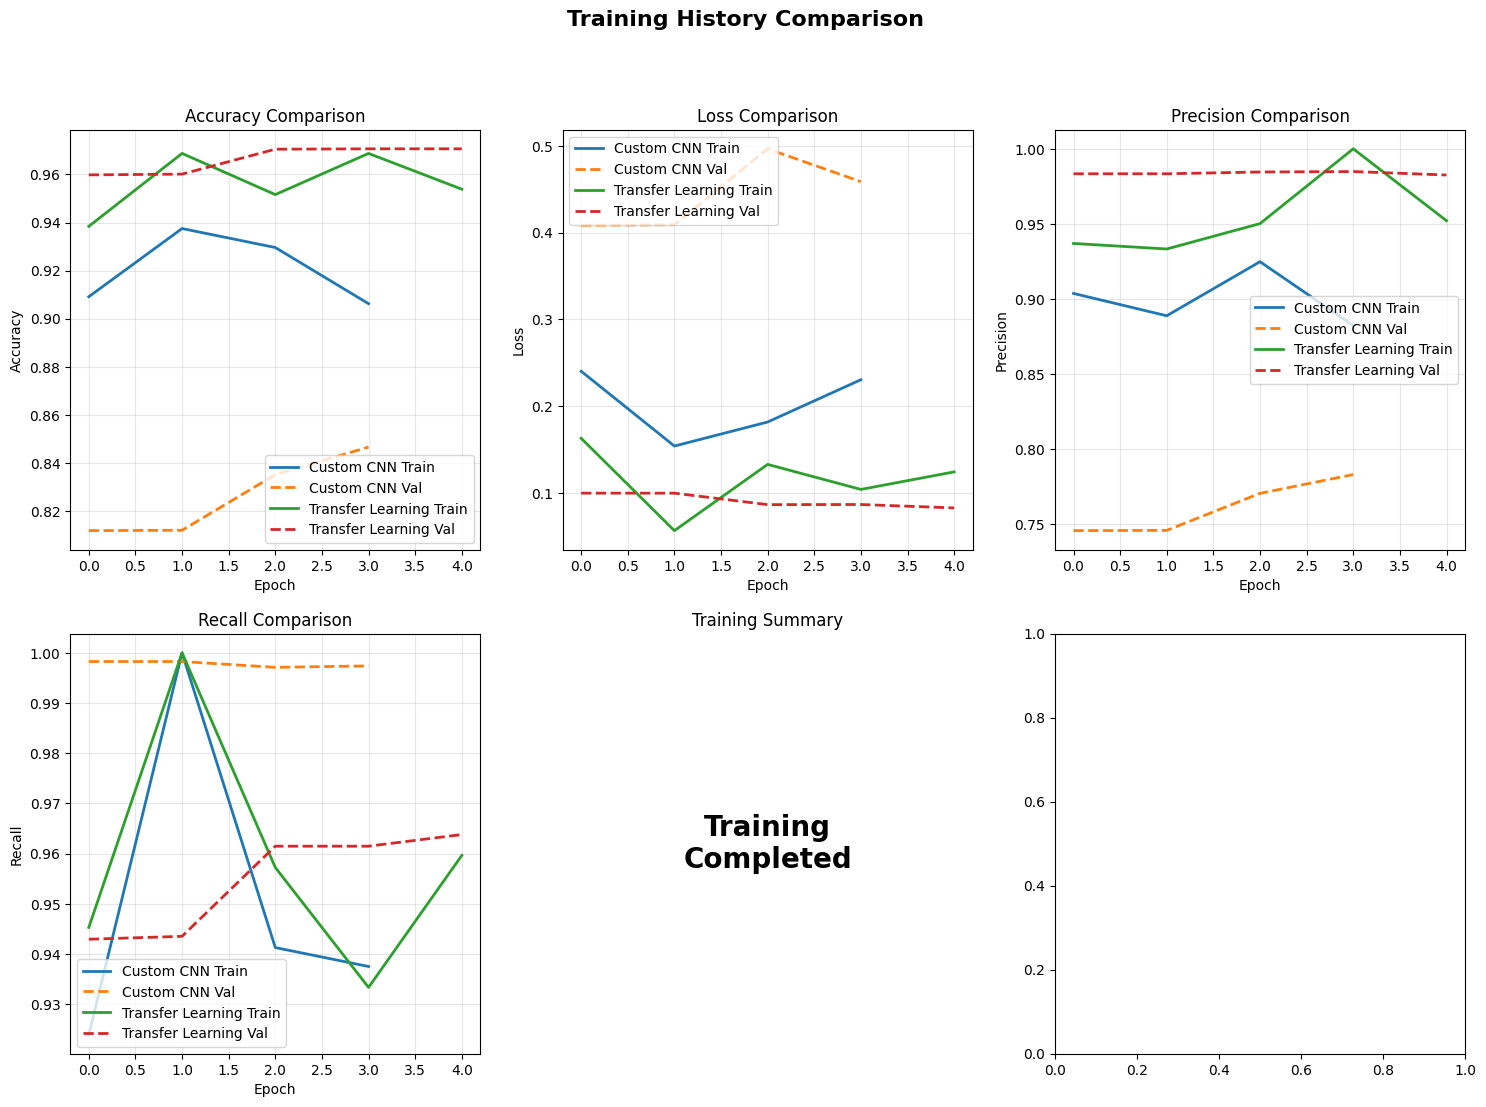

In [29]:
final_accs = {}
if history1 is not None:
    final_accs[model1_name] = history1.history['val_accuracy'][-1]
if history2 is not None:
    final_accs[model2_name] = history2.history['val_accuracy'][-1]

if final_accs:
    models = list(final_accs.keys())
    accuracies = list(final_accs.values())

    bars = axes[1, 2].bar(models, accuracies, color=['skyblue', 'lightcoral'], alpha=0.7)
    axes[1, 2].set_title('Final Validation Accuracy')
    axes[1, 2].set_ylabel('Accuracy')
    axes[1, 2].set_ylim(0, 1)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
else:
    axes[1, 2].text(0.5, 0.5, 'No final\naccuracies', ha='center', va='center',
                   transform=axes[1, 2].transAxes, fontsize=12, color='gray')
    axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Plot training histories if they exist
plot_training_history(cnn_history, transfer_history)


# --- 7. Model Evaluation and Performance Analysis ---


==================== Custom CNN Evaluation ====================
197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 394ms/step
Test Loss: 0.3801
Test Accuracy: 0.8203
Test Precision: 0.7554
Test Recall: 0.9977

Detailed Classification Report:
              precision    recall  f1-score   support

  nowildfire       1.00      0.60      0.75      2820
    wildfire       0.76      1.00      0.86      3480

    accuracy                           0.82      6300
   macro avg       0.88      0.80      0.80      6300
weighted avg       0.86      0.82      0.81      6300



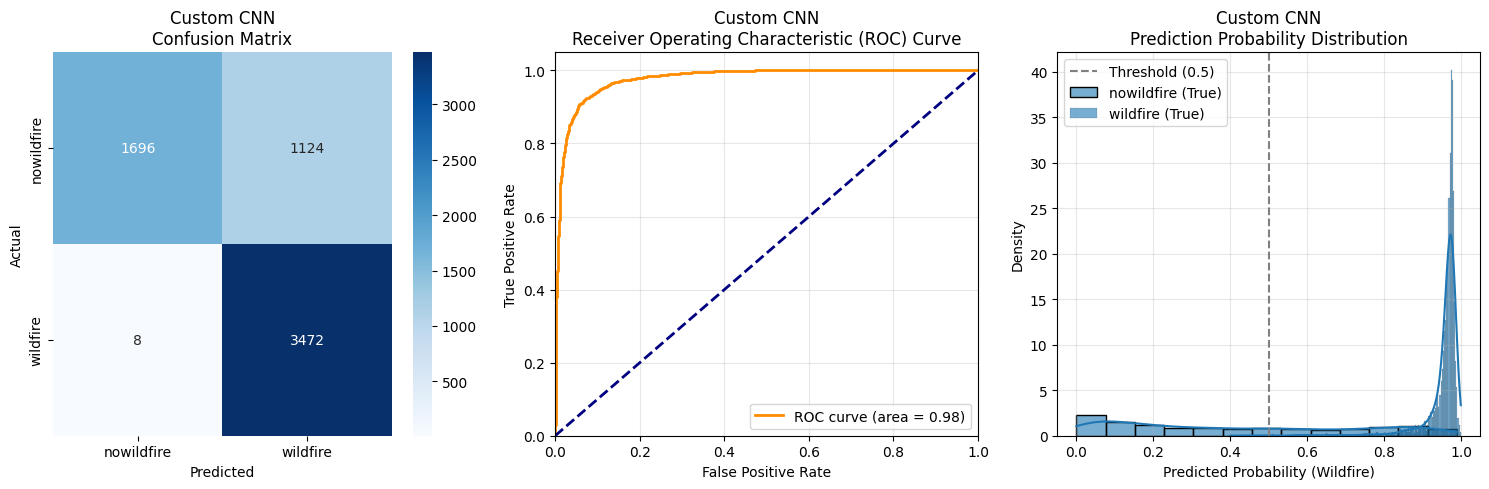


==================== Transfer Learning Model (ResNet50) Evaluation ====================
197/197 ━━━━━━━━━━━━━━━━━━━━ 34s 148ms/step
Test Loss: 0.0666
Test Accuracy: 0.9768
Test Precision: 0.9877
Test Recall: 0.9701

Detailed Classification Report:
              precision    recall  f1-score   support

  nowildfire       0.96      0.99      0.97      2820
    wildfire       0.99      0.97      0.98      3480

    accuracy                           0.98      6300
   macro avg       0.98      0.98      0.98      6300
weighted avg       0.98      0.98      0.98      6300



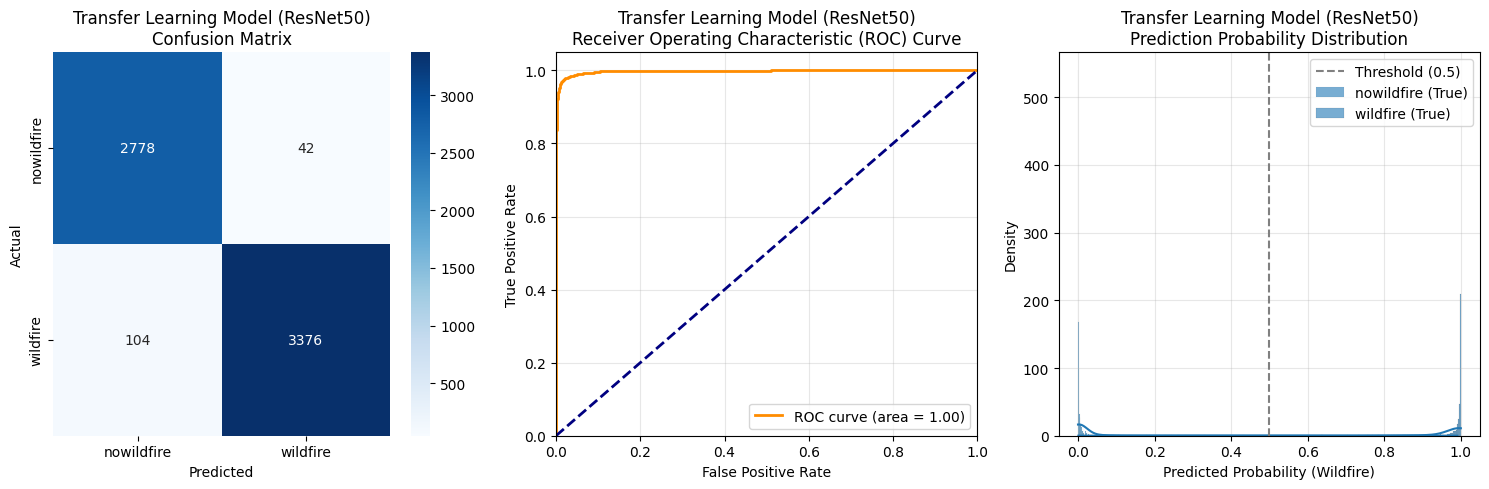


--- Wildfire Prediction Workflow Completed ---


In [22]:

def comprehensive_model_evaluation_with_generator(model, test_generator, model_name):
    """
    Performs comprehensive model evaluation using a test generator.
    Includes classification report, confusion matrix, ROC curve, and prediction distribution.
    """
    print(f"\n{'='*20} {model_name} Evaluation {'='*20}")
    
    if test_generator.samples == 0:
        print(f"Skipping {model_name} evaluation as test generator is empty.")
        return

    # Reset the generator to ensure predictions start from the beginning of the test set
    test_generator.reset() 
    
    # Make predictions
    # steps calculates the total number of batches needed to cover all samples
    y_pred_proba = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + (test_generator.samples % test_generator.batch_size != 0), verbose=1)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Get true labels from the generator. This uses the internal order of the generator.
    # test_generator.classes contains the true labels for all files in the directory
    # test_generator.index_array maintains the order in which files are processed (important if shuffle=False)
    y_true = test_generator.classes[test_generator.index_array]
    
    # Ensure y_true and y_pred have the same number of samples
    # This might be necessary if the last batch of the generator is incomplete
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    y_pred_proba = y_pred_proba[:min_len]

    # Overall test accuracy
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    
    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[CLASS_NAMES[0], CLASS_NAMES[1]]))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(15, 5))
    
    # Confusion Matrix Heatmap
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[CLASS_NAMES[0], CLASS_NAMES[1]], yticklabels=[CLASS_NAMES[0], CLASS_NAMES[1]])
    plt.title(f'{model_name}\nConfusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # ROC Curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba.flatten())
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name}\nReceiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Prediction probability distribution
    plt.subplot(1, 3, 3)
    # Filter probabilities based on true labels
    sns.histplot(y_pred_proba[y_true == 0], color='skyblue', label=f'{CLASS_NAMES[0]} (True)', kde=True, stat='density', alpha=0.6)
    sns.histplot(y_pred_proba[y_true == 1], color='orangered', label=f'{CLASS_NAMES[1]} (True)', kde=True, stat='density', alpha=0.6)
    plt.axvline(x=0.5, color='gray', linestyle='--', label='Threshold (0.5)')
    plt.title(f'{model_name}\nPrediction Probability Distribution')
    plt.xlabel('Predicted Probability (Wildfire)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Evaluate the models if they were trained
if cnn_history is not None:
    comprehensive_model_evaluation_with_generator(custom_cnn, test_gen, "Custom CNN")
if transfer_history is not None:
    comprehensive_model_evaluation_with_generator(transfer_model, test_gen, "Transfer Learning Model (ResNet50)")

print("\n--- Wildfire Prediction Workflow Completed ---")